In [17]:
import matplotlib.pyplot as plt
import numpy as np
import pickle
%matplotlib inline

from scipy.optimize import curve_fit

import warnings
warnings.filterwarnings("ignore")

plt.rcParams['axes.grid'] = False
plt.style.context('Solarize_Light2')

In [18]:
def average_outs(outs):
    return np.array([sum(outs[i*512:(i+1)*512])/512 for i in range(num_temps)])

def stds_outs(outs):
    return np.power(np.array([np.std(outs[i*512:(i+1)*512]) for i in range(num_temps)]), 2)

num_temps = 100
num_epochs = 3

markers = ['.', '^', 'X', 's', '*', 'p']
colors = ['blue', 'orange', 'green', 'red', 'm', 'gold']

## Ising square lattice

## discrete

In [19]:
M = 0.125

### get temperature range and predictions of NN ###

with open('ts_crit_sq.pkl', 'rb') as f:
    get_crit_T = pickle.load(f)
    
T_c = get_crit_T[M]
T = np.linspace(T_c - 0.3, T_c + 0.3, num_temps)

Ls = np.array([20, 30, 60, 80, 100])
outs_ = []
num_epochs = 3

for i, L in enumerate(Ls):
    with open(f'data_outputs/square/{M}_{L}_{num_temps}_{num_epochs}_epochs.npy', 'rb') as f:
        outs_.append(np.squeeze(np.load(f)))

In [28]:
### get discrete T_c^* from NN outputs

ts_f = []
for i, L in enumerate(Ls):
    diff = [np.abs(average_outs(outs_[i][:, 0])[j] - average_outs(outs_[i][:, 1]))[j] for j in range(num_temps)]
    ts_f.append(T[np.argmin(diff)])
ts_f = np.array(ts_f)

In [29]:
### get discrete T_c^* from variance of NN outputs

ts_v = []
for i, L in enumerate(Ls):
    #diff = [np.abs(stds_outs(outs_[i][:, 0])[j] - stds_outs(outs_[i][:, 1]))[j] for j in range(num_temps)]
    ts_v.append(T[np.argmax(stds_outs(outs_[i][:, 0]))])
ts_v = np.array(ts_v)

In [32]:
print(ts_f, ts_f - T_c, '\n')
print(ts_v, ts_v - T_c)

[0.99961725 0.99355664 0.99355664 0.99355664 0.98749603] [0.02727273 0.02121212 0.02121212 0.02121212 0.01515152] 

[0.99961725 0.99355664 0.99355664 0.99355664 0.98749603] [0.02727273 0.02121212 0.02121212 0.02121212 0.01515152]


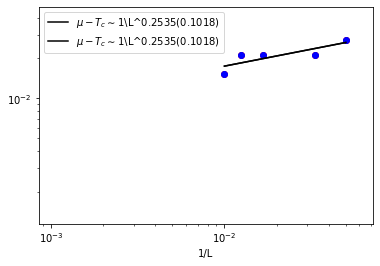

In [31]:
def line(x, a, b):
    return a*x + b 

def line_fit(y, x):
    popt, pcov = curve_fit(line, xdata=x, ydata=y, absolute_sigma=False, maxfev=100000)
    return popt, pcov

ls = 1 / Ls

cs_f = ts_f - T_c 
pl_f, pcov_f = line_fit(y=np.log(np.abs(cs_f)), x=np.log(ls))
perr_f = np.sqrt(np.diag(pcov_f))

cs_v = ts_v - T_c 
pl_v, pcov_v = line_fit(y=np.log(np.abs(cs_v)), x=np.log(ls))
perr_v = np.sqrt(np.diag(pcov_v))

plt.scatter(ls, cs_f, color='red')
plt.scatter(ls, cs_v, color='blue')
#plt.errorbar(ls, cs_, yerr=perr_[:, 1], fmt="o", color='black', label='$\mu-T_c$')

plt.plot(ls, np.exp(line(np.log(ls), pl_f[0], pl_f[1])), color='black', label='$\mu-T_c\sim$1\L^{0:.4f}({1:.4f})'.format(round(pl_f[0], 4), round(perr_f[0], 4)))
plt.plot(ls, np.exp(line(np.log(ls), pl_v[0], pl_v[1])), color='black', label='$\mu-T_c\sim$1\L^{0:.4f}({1:.4f})'.format(round(pl_v[0], 4), round(perr_v[0], 4)))

#plt.title(f'M = {M}')
plt.xlabel('1/L')
# plt.ylabel('$\mu-T_c$')
plt.xscale('log')
plt.yscale('log')
plt.legend()
# plt.savefig(f'images/{M}-mu.png')

## continious